# CS4035 - Cyber Data Analytics
## Lab 4

### Submit on brightspace (zip file with the name Group_xx.zip)
This jupyter file completed with code, plots, figures and report for each question. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.

(if you used hard-to-get libraries) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name : Sayak Mukherjee
### ID : 5222273

## Student 2
### Name :
### ID :

## README

Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix , accuracy_score
from tqdm import tqdm

## 1. Preparation (0 points)

### 1a. Load the dataset and split it into a train and test set

In [2]:
data_X = np.load('data/X.npy') # 30396 samples, 22761 features
data_y = np.load('data/y.npy')

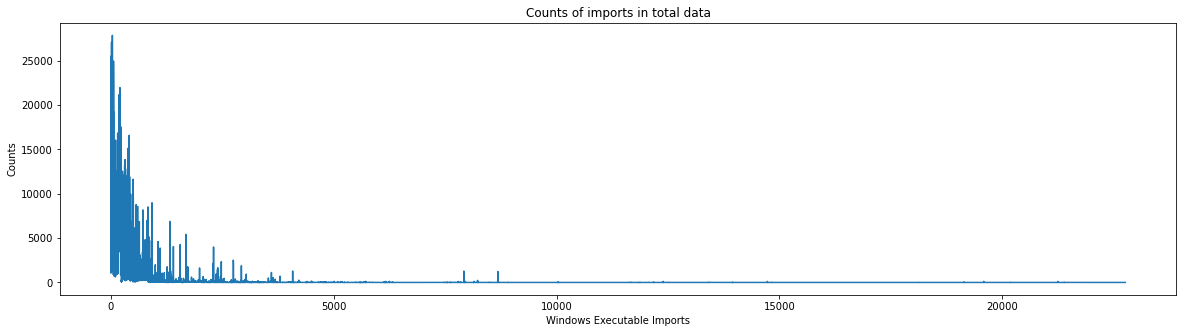

In [3]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data_X.sum(axis=0))
ax.set_xlabel('Windows Executable Imports')
ax.set_ylabel('Counts')
plt.title('Counts of imports in total data')
plt.show()

First ~1000 imports occur more frequently in the data

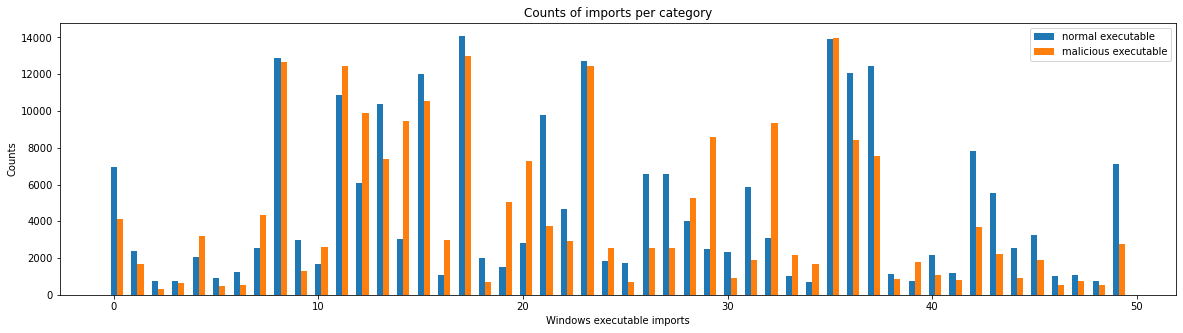

In [4]:
width = 0.3

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(np.array(range(50)), data_X[data_y==0].sum(axis=0)[:50], width=width, label='normal executable')
ax.bar(np.array(range(50)) + width, data_X[data_y==1].sum(axis=0)[:50], width=width, label='malicious executable')
ax.set_xlabel('Windows executable imports')
ax.set_ylabel('Counts')
plt.title('Counts of imports per category')
plt.legend()
plt.show()

Some of the imports are more predominant in the malicious than in the normal executable

### Training a linear model

In [5]:
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=42)

In [6]:
# loss='log_loss' works on version 1.1 and above of scikit-learn
# for lower versions use loss=‘log’. 
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

clf = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')

In [7]:
clf.fit(train_X, train_y)

SGDClassifier(loss='log_loss')

In [8]:
clf_coef = clf.coef_.reshape(-1)

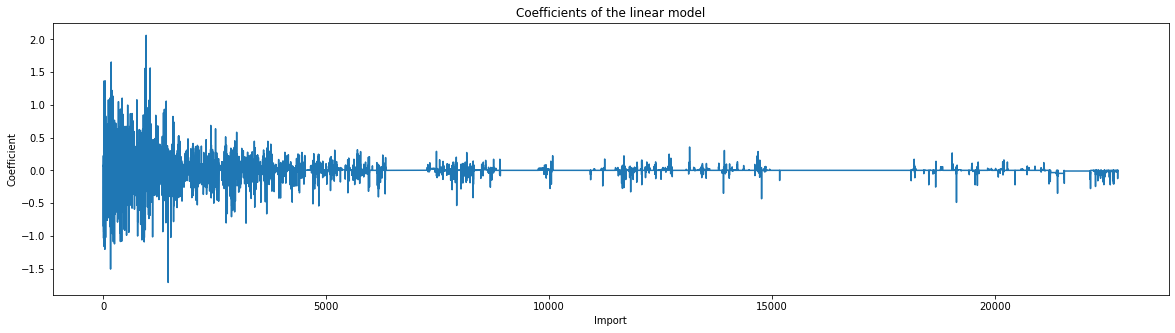

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(clf_coef)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Import')
plt.title("Coefficients of the linear model")

plt.show()

In [10]:
pred_proba = clf.predict_proba(test_X)[:, 1]
pred_label = clf.predict(test_X)

tn, fp, fn, tp = confusion_matrix(test_y, pred_label).ravel()
roc = roc_auc_score(test_y, pred_proba)
acc = accuracy_score(test_y, pred_label)

print(f'Area under ROC: {round(roc, 4)}')
print(f'Accuracy: {round(acc, 4)}')
print(f'TP: {tp}; FP: {fp}, FN: {fn}, TN: {tn}')

Area under ROC: 0.9774
Accuracy: 0.9204
TP: 2854; FP: 313, FN: 171, TN: 2742


## 2. Attacking linear models (5 Points)

### 2a. Implementing useless import attacks


In [11]:
# indexes of samples for malicious executables

ATTACT_INDEXES_TEST = np.where(test_y == 1)[0]
ATTACT_INDEXES_TRAIN = np.where(train_y == 1)[0]

In [12]:
def evade(sample, coef, verbose=True):
    
    def calc_result(x):
        # estimate the output of linear model
        
        return (coef * x).sum()
    
    def update_sample(x, val):
        # update the corresponding import counts
        
        for ind in neg_coeff_index:
            x[ind] = val
        return x
    
    adv_sample = sample.astype(float)
    
    # value to replace at indexes 
    # to make model misclassify
    adv_value = 10
    
    # find the top-10 negative coefficients
    neg_coeff_index = np.argsort(clf.coef_.reshape(-1))[:10]
    
    # find the current estimate
    curr_res = calc_result(adv_sample)
    
    num_iter = 0
    tolerance = 10 # max-iterations
    
    # loop till adversarial example found
    while curr_res > 0:
        
        # Update sample
        adv_sample = update_sample(adv_sample, adv_value)
        
        # re-estimate output
        curr_res = calc_result(adv_sample)
        
        # increment the adversarial count
        adv_value *= 10
        
        # code to prevent infinite loop
        if num_iter > tolerance:
            if verbose:
                print(f"Could not find adversarial example")
                
            return sample
            
        num_iter += 1
    
    if verbose:
        print(f'Found adversarial sample in {num_iter} iterations')
    
    return adv_sample

In [13]:
is_correct = (pred_label == test_y).astype(int) 
correct_indexes = np.where(is_correct == 1)[0] # indexes of correctly classified samples

# indexes of correctly identified malicious code
correctly_identified_attacks = np.intersect1d(ATTACT_INDEXES_TEST, correct_indexes) 

In [14]:
# Check performance for one sample

ind = np.random.choice(correctly_identified_attacks, 1)[0]

pred = clf.predict([test_X[ind]])
print(f'Before attack: {pred}')

adv_sample = evade(test_X[ind].copy(), clf_coef)

pred = clf.predict([adv_sample])
print(f'After attack: {pred}')

Before attack: [1]
Found adversarial sample in 1 iterations
After attack: [0]


In [15]:
def useless_import_attack(dataframe, coef, indexes):
    '''
    Modifies correctly classified attacks 
    to be misclassified by model
    '''
    for ind in indexes:
        dataframe[ind] = evade(dataframe[ind], coef, verbose=False)
    return dataframe

In [16]:
adv_X = useless_import_attack(test_X.copy(), coef = clf_coef, indexes=ATTACT_INDEXES_TEST)

In [17]:
pred_proba = clf.predict_proba(adv_X)[:, 1]
pred_label = clf.predict(adv_X)

tn, fp, fn, tp = confusion_matrix(test_y, pred_label).ravel()
roc = roc_auc_score(test_y, pred_proba)
acc = accuracy_score(test_y, pred_label)

print(f'Area under ROC: {round(roc, 4)}')
print(f'Accuracy: {round(acc, 4)}')
print(f'TP: {tp}; FP: {fp}, FN: {fn}, TN: {tn}')

Area under ROC: 0.1661
Accuracy: 0.5163
TP: 397; FP: 313, FN: 2628, TN: 2742


### 2b. Analysis and answers to the questions

The accuracy of the model drops by approximately `0.4` (Note: Actual differences depend on the initialization). This shows that the logistic regression model is not robust to simple adversarial attacks. This can be attributed to the negative coefficients for some of the features. Adjusting the values of the values of the features having the negative coefficient such that the overall output is positive causes the overall result to be negative. This results in the model misclassifiying malicious samples as benign.

## 3. Improving robustness by hardening (5 Points)

### 3a. Implementing hardening

In [18]:
def hardening_train(model, epochs):
    
    acc_normal = []
    acc_adv = []
    
    samples_to_modify = (int)(len(ATTACT_INDEXES_TRAIN) * 0.5) # attack 50% of the malicious rows
    
    adv_train_X = train_X.copy()
    
    for i in tqdm(range(epochs)):
        # Fit the model for 1 epoch
        model.partial_fit(adv_train_X, train_y, classes=[0,1])
        
        chosen_indexes = np.random.choice(ATTACT_INDEXES_TRAIN, samples_to_modify) 
        
        # attack train data for hardening        
        adv_train_X = useless_import_attack(adv_train_X.copy(), coef=model.coef_, indexes=chosen_indexes)
        
        # test performance on normal test data
        pred_label = model.predict(test_X)
        acc_normal.append(accuracy_score(test_y, pred_label))
        
        # generate adversarial test data
        adv_X = useless_import_attack(test_X.copy(), coef = model.coef_, indexes = ATTACT_INDEXES_TEST)
        
        # test performance on adversarial test data
        pred_label = model.predict(adv_X)
        acc_adv.append(accuracy_score(test_y, pred_label))
        
    return acc_normal, acc_adv, model

In [19]:
clf = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')

In [20]:
normal_accs, adversarial_accs, model = hardening_train(clf, 30)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [11:24<00:00, 22.81s/it]


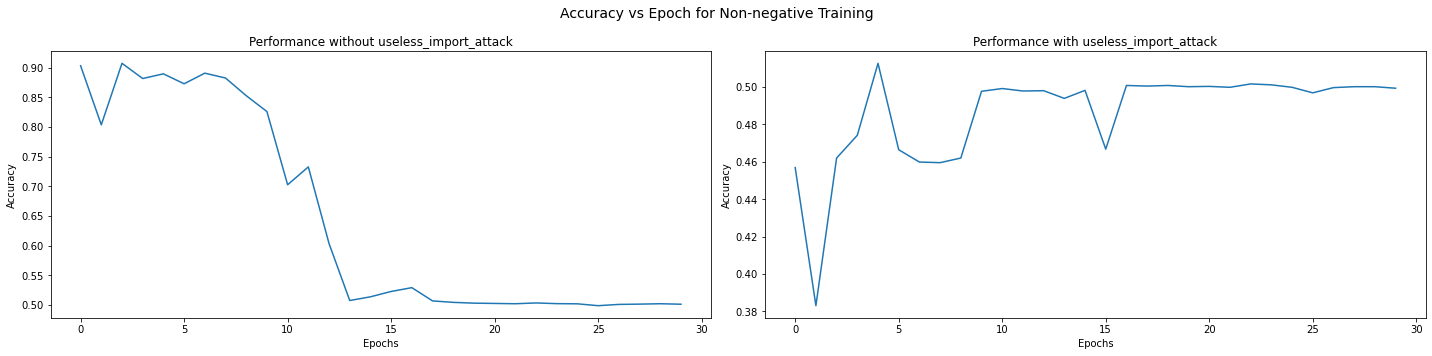

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20, 5), layout='tight')

ax[0].plot(normal_accs)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Performance without useless_import_attack')

ax[1].plot(adversarial_accs)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Performance with useless_import_attack')

fig.suptitle('Accuracy vs Epoch for Non-negative Training', fontsize=14)

plt.show()

### 3b. Analysis and answers to the questions

After hardening the performance on the normal test set decreases from `0.9` to `0.5`. However, the performamce on the adversarial test set improves from `0.38` to `0.5`. Hence we can conclude that hardening does improve the performance and the model reaches a constant performance irrespective of adversarial attack. It takes approximately `15` epochs for the model to reach a constant performance on both the test sets.

## 4. Training non-negative linear models (5 Points)

### 4a. Implement non-negative logistic regression using SGD

In [25]:
clf = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')

In [26]:
def non_neg_train(model, epochs):
    
    acc_normal = []
    acc_adv = []
    
    for i in tqdm(range(epochs)):
        # Fit the model for 1 epoch
        model.partial_fit(train_X, train_y, classes=[0,1])
        
        # clip the coefficients to make then non-zero
        model.coef_ = np.clip(model.coef_, a_min=0, a_max=None)
        
        # test performance on normal test data
        pred_label = model.predict(test_X)
        acc_normal.append(accuracy_score(test_y, pred_label))
        
        # generate adversarial test data
        adv_X = useless_import_attack(test_X.copy(), coef = model.coef_, indexes = ATTACT_INDEXES_TEST)
        
        # test performance on adversarial test data
        pred_label = model.predict(adv_X)
        acc_adv.append(accuracy_score(test_y, pred_label))
        
    return acc_normal, acc_adv, model

In [27]:
normal_accs, adversarial_accs, model = non_neg_train(clf, 30)

100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:49<00:00,  7.64s/it]


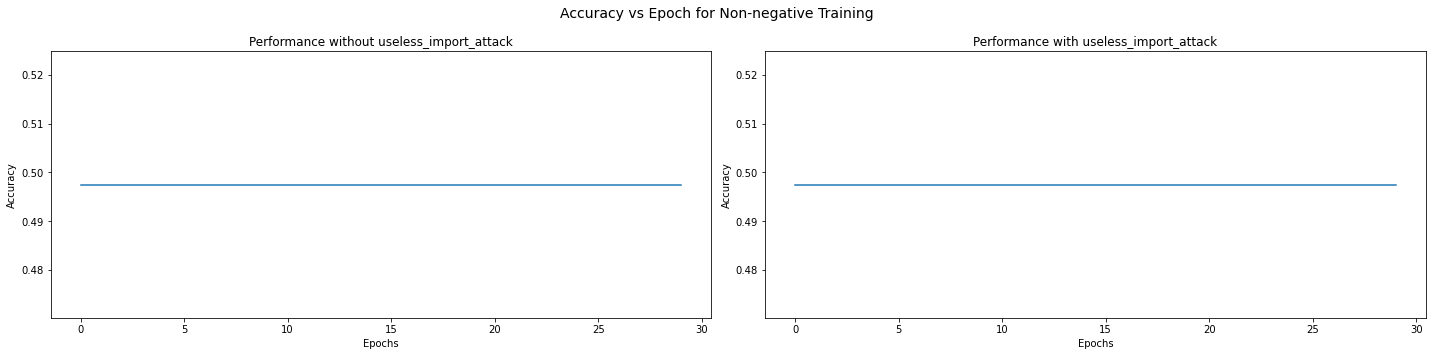

In [28]:
fig, ax = plt.subplots(1,2, figsize=(20, 5), layout='tight')

ax[0].plot(normal_accs)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Performance without useless_import_attack')

ax[1].plot(adversarial_accs)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Performance with useless_import_attack')

fig.suptitle('Accuracy vs Epoch for Non-negative Training', fontsize=14)

plt.show()

### 4b. Analysis and answers to the questions.

With non-negative clipping, the `useless_import_attack` is no longer valid as there is no feature with negative coefficient to exploit. We can see the performance of the classifier is the same with and without the adversarial attack unlike in the case of hardening.

## 5. Bonus: robust decision trees for fraud detection (5 Points)

### 5a. Train and analyze a regular decision tree for fraud detection

### 5b. Train and analyze a robust decision tree (GROOT) for fraud detection

### 5c. Evaluate the robustness of the two models